In [ ]:
questions asked: what did you learn most? whats the reason its actually better. 

In [1]:
import math
import time
from typing import Callable, Iterable, Tuple, Dict, List

import torch
from torch import nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
class Grams(Optimizer):
    """
    Parameters:
        params (`Iterable[nn.parameter.Parameter]`):
            Iterable of parameters to optimize or dictionaries defining parameter groups.
        lr (`float`, *optional*, defaults to 0.001):
            The learning rate to use.
        betas (`Tuple[float,float]`, *optional*, defaults to `(0.9, 0.999)`):
            Adam's betas parameters (b1, b2).
        eps (`float`, *optional*, defaults to 1e-06):
            Adam's epsilon for numerical stability.
        weight_decay (`float`, *optional*, defaults to 0.0):
            Decoupled weight decay to apply.
        correct_bias (`bool`, *optional*, defaults to `True`):
            Whether or not to correct bias in Adam (for instance, in Bert TF repository they use `False`).
    """

    def __init__(
        self,
        params: Iterable[nn.parameter.Parameter],
        lr: float = 1e-3,
        betas: Tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-6,
        weight_decay: float = 0.0,
        correct_bias: bool = True,
    ):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr} - should be >= 0.0")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(
                f"Invalid beta parameter: {betas[0]} - should be in [0.0, 1.0)"
            )
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(
                f"Invalid beta parameter: {betas[1]} - should be in [0.0, 1.0)"
            )
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps} - should be >= 0.0")
        defaults = {
            "lr": lr,
            "betas": betas,
            "eps": eps,
            "weight_decay": weight_decay,
            "correct_bias": correct_bias,
        }
        super().__init__(params, defaults)
        self.init_lr = lr

    @torch.no_grad()
    def step(self, closure: Callable = None):
        """
        Performs a single optimization step.

        Arguments:
            closure (`Callable`, *optional*): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for i, p in enumerate(group["params"]):
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]

                if "step" not in state:
                    state["step"] = 0

                # State initialization
                if "exp_avg" not in state:
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(grad)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(grad)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                if group["weight_decay"] > 0.0:
                    p.add_(p, alpha=(-group["lr"] * group["weight_decay"]))

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                exp_avg.mul_(beta1).add_(grad, alpha=(1.0 - beta1))
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1.0 - beta2)
                denom = exp_avg_sq.sqrt().add_(group["eps"])

                step_size = group["lr"]
                if group["correct_bias"]:  # No bias correction for Bert
                    bias_correction1 = 1.0 - beta1 ** state["step"]
                    bias_correction2 = 1.0 - beta2 ** state["step"]
                    step_size = (
                        step_size * math.sqrt(bias_correction2) / bias_correction1
                    )

                grad.sign_().mul_(exp_avg.abs())
                p.addcdiv_(grad, denom, value=-step_size)

        return loss

In [3]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

batch_size = 128

def get_dataloaders(dataset_name: str = "mnist", batch_size: int = 128):
    if dataset_name.lower() == "mnist":
        dataset_cls = datasets.MNIST
    elif dataset_name.lower() in ["fashion-mnist", "fashion_mnist", "fashion"]:
        dataset_cls = datasets.FashionMNIST
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    train_dataset = dataset_cls("./data", train=True, download=True, transform=transform)
    test_dataset  = dataset_cls("./data", train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader

train_loader_mnist, test_loader_mnist = get_dataloaders("mnist", batch_size)
train_loader_fashion, test_loader_fashion = get_dataloaders("fashion-mnist", batch_size)

print("MNIST:", len(train_loader_mnist.dataset), "train,", len(test_loader_mnist.dataset), "test")
print("Fashion-MNIST:", len(train_loader_fashion.dataset), "train,", len(test_loader_fashion.dataset), "test")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 58.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.07MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 15.7MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.37MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 315kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.44MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 38.4MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

MNIST: 60000 train, 10000 test
Fashion-MNIST: 60000 train, 10000 test


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1: 1x28x28 -> 32x28x28
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        # Block 2: 32x28x28 -> 64x14x14 (after pool)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # Block 3: 64x14x14 -> 128x7x7 (after pool)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # After two 2x2 pools: 28 -> 14 -> 7, so 128 * 7 * 7 features
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))     # 1x28x28 -> 32x28x28

        # Block 2
        x = F.relu(self.bn2(self.conv2(x)))     # 32x28x28 -> 64x28x28
        x = self.pool(x)                        # 64x28x28 -> 64x14x14

        # Block 3
        x = F.relu(self.bn3(self.conv3(x)))     # 64x14x14 -> 128x14x14
        x = self.pool(x)                        # 128x14x14 -> 128x7x7

        x = x.view(x.size(0), -1)               # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


def create_model():
    return CNN().to(device)

model = create_model()
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [5]:
@torch.no_grad()
def evaluate(model: nn.Module, dataloader: DataLoader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        total_loss += loss.item() * images.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, total_correct / total


def train_with_tracking(
    optimizer_name: str,
    optimizer_factory,
    train_loader: DataLoader,
    test_loader: DataLoader,
    num_epochs: int = 5,
    record_grad_norms: bool = False,
    grad_layers: List[str] = None,
):

    print(f"\n=== Optimizer: {optimizer_name} ===")
    set_seed(42)
    model = create_model()
    optimizer = optimizer_factory(model.parameters())

    named_params = dict(model.named_parameters())

    history = {
        "iter_steps": [],
        "iter_losses": [],
        "iter_times": [],
        "epoch_val_loss": [],
        "epoch_val_acc": [],
        "grad_norms": {},
    }

    if record_grad_norms and grad_layers is not None:
        for layer in grad_layers:
            history["grad_norms"][layer] = []

    global_step = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()

        pbar = tqdm(train_loader, desc=f"{optimizer_name} Epoch {epoch+1}/{num_epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            if record_grad_norms and grad_layers is not None:
                for layer_name in grad_layers:
                    if layer_name in named_params and named_params[layer_name].grad is not None:
                        gnorm = named_params[layer_name].grad.norm().item()
                    else:
                        gnorm = 0.0
                    history["grad_norms"][layer_name].append(gnorm)

            optimizer.step()

            global_step += 1
            history["iter_steps"].append(global_step)
            history["iter_losses"].append(loss.item())
            history["iter_times"].append(time.time() - start_time)

            pbar.set_postfix(loss=loss.item())

        val_loss, val_acc = evaluate(model, test_loader)
        history["epoch_val_loss"].append(val_loss)
        history["epoch_val_acc"].append(val_acc)
        print(f"Epoch {epoch+1}: Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")

    return history

In [6]:
def gd_factory(params, lr: float = 0.01, weight_decay: float = 0.0):
    return torch.optim.SGD(params, lr=lr, momentum=0.0, weight_decay=weight_decay)

def sgd_factory(params, lr: float = 0.01, weight_decay: float = 0.0):
    return torch.optim.SGD(params, lr=lr, momentum=0.0, weight_decay=weight_decay)

def momentum_factory(params, lr: float = 0.01, weight_decay: float = 0.0):
    return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)

def nesterov_factory(params, lr: float = 0.01, weight_decay: float = 0.0):
    return torch.optim.SGD(params, lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)

def adam_factory(params, lr: float = 1e-3, weight_decay: float = 0.0):
    return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

def adamw_factory(params, lr: float = 1e-3, weight_decay: float = 1e-2):
    return torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)

def grams_factory(params, lr: float = 1e-3, weight_decay: float = 0.0):
    return Grams(params, lr=lr, weight_decay=weight_decay)

In [7]:
optimizers_main = [
    ("Gradient Descent (GD)", lambda p: gd_factory(p, lr=0.01)),
    ("SGD",                   lambda p: sgd_factory(p, lr=0.01)),
    ("Momentum",              lambda p: momentum_factory(p, lr=0.01)),
    ("Nesterov Momentum",     lambda p: nesterov_factory(p, lr=0.01)),
    ("Adam",                  lambda p: adam_factory(p, lr=1e-3)),
    ("AdamW",                 lambda p: adamw_factory(p, lr=1e-3, weight_decay=1e-2)),
    ("Grams",                 lambda p: grams_factory(p, lr=1e-3)),
]

histories_mnist = {}
for name, factory in optimizers_main:
    histories_mnist[name] = train_with_tracking(
        optimizer_name=name,
        optimizer_factory=factory,
        train_loader=train_loader_mnist,
        test_loader=test_loader_mnist,
        num_epochs=10,
        record_grad_norms=False,
    )


=== Optimizer: Gradient Descent (GD) ===


Gradient Descent (GD) Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0858, Val acc=0.9758


Gradient Descent (GD) Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0588, Val acc=0.9816


Gradient Descent (GD) Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0480, Val acc=0.9861


Gradient Descent (GD) Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0404, Val acc=0.9879


Gradient Descent (GD) Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0349, Val acc=0.9887


Gradient Descent (GD) Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: Val loss=0.0347, Val acc=0.9889


Gradient Descent (GD) Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: Val loss=0.0362, Val acc=0.9880


Gradient Descent (GD) Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: Val loss=0.0293, Val acc=0.9909


Gradient Descent (GD) Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: Val loss=0.0291, Val acc=0.9908


Gradient Descent (GD) Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: Val loss=0.0286, Val acc=0.9905

=== Optimizer: SGD ===


SGD Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0858, Val acc=0.9756


SGD Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0589, Val acc=0.9815


SGD Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0481, Val acc=0.9861


SGD Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0405, Val acc=0.9878


SGD Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0349, Val acc=0.9887


SGD Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: Val loss=0.0346, Val acc=0.9890


SGD Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: Val loss=0.0359, Val acc=0.9879


SGD Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: Val loss=0.0294, Val acc=0.9903


SGD Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: Val loss=0.0290, Val acc=0.9909


SGD Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: Val loss=0.0284, Val acc=0.9907

=== Optimizer: Momentum ===


Momentum Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0565, Val acc=0.9821


Momentum Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0265, Val acc=0.9912


Momentum Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0321, Val acc=0.9895


Momentum Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0213, Val acc=0.9928


Momentum Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0314, Val acc=0.9897


Momentum Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: Val loss=0.0235, Val acc=0.9927


Momentum Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: Val loss=0.0217, Val acc=0.9935


Momentum Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: Val loss=0.0333, Val acc=0.9892


Momentum Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: Val loss=0.0255, Val acc=0.9926


Momentum Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: Val loss=0.0245, Val acc=0.9921

=== Optimizer: Nesterov Momentum ===


Nesterov Momentum Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0493, Val acc=0.9843


Nesterov Momentum Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0283, Val acc=0.9909


Nesterov Momentum Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0276, Val acc=0.9914


Nesterov Momentum Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0231, Val acc=0.9925


Nesterov Momentum Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0263, Val acc=0.9913


Nesterov Momentum Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: Val loss=0.0218, Val acc=0.9933


Nesterov Momentum Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: Val loss=0.0221, Val acc=0.9930


Nesterov Momentum Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: Val loss=0.0326, Val acc=0.9905


Nesterov Momentum Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: Val loss=0.0261, Val acc=0.9917


Nesterov Momentum Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: Val loss=0.0244, Val acc=0.9926

=== Optimizer: Adam ===


Adam Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0396, Val acc=0.9883


Adam Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0366, Val acc=0.9874


Adam Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0403, Val acc=0.9873


Adam Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0261, Val acc=0.9907


Adam Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0318, Val acc=0.9903


Adam Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: Val loss=0.0255, Val acc=0.9916


Adam Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: Val loss=0.0325, Val acc=0.9901


Adam Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: Val loss=0.0210, Val acc=0.9932


Adam Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: Val loss=0.0244, Val acc=0.9933


Adam Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: Val loss=0.0312, Val acc=0.9923

=== Optimizer: AdamW ===


AdamW Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0449, Val acc=0.9857


AdamW Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0292, Val acc=0.9900


AdamW Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0341, Val acc=0.9887


AdamW Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0271, Val acc=0.9911


AdamW Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0329, Val acc=0.9908


AdamW Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: Val loss=0.0227, Val acc=0.9929


AdamW Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: Val loss=0.0285, Val acc=0.9910


AdamW Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: Val loss=0.0261, Val acc=0.9927


AdamW Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: Val loss=0.0233, Val acc=0.9934


AdamW Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: Val loss=0.0336, Val acc=0.9896

=== Optimizer: Grams ===


Grams Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0493, Val acc=0.9837


Grams Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0398, Val acc=0.9874


Grams Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0310, Val acc=0.9897


Grams Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0432, Val acc=0.9883


Grams Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0359, Val acc=0.9910


Grams Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: Val loss=0.0551, Val acc=0.9870


Grams Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: Val loss=0.0299, Val acc=0.9918


Grams Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: Val loss=0.0317, Val acc=0.9908


Grams Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: Val loss=0.0318, Val acc=0.9900


Grams Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: Val loss=0.0328, Val acc=0.9906


In [8]:
def smooth_and_downsample(x, y, ma_window=50, max_points=300):
    x = np.asarray(x)
    y = np.asarray(y)

    if len(y) >= ma_window:
        kernel = np.ones(ma_window) / ma_window
        y_smooth = np.convolve(y, kernel, mode="valid")
        x_smooth = x[ma_window-1:]
    else:
        x_smooth, y_smooth = x, y

    if len(x_smooth) > max_points:
        idx = np.linspace(0, len(x_smooth)-1, max_points).astype(int)
        x_smooth = x_smooth[idx]
        y_smooth = y_smooth[idx]

    return x_smooth, y_smooth

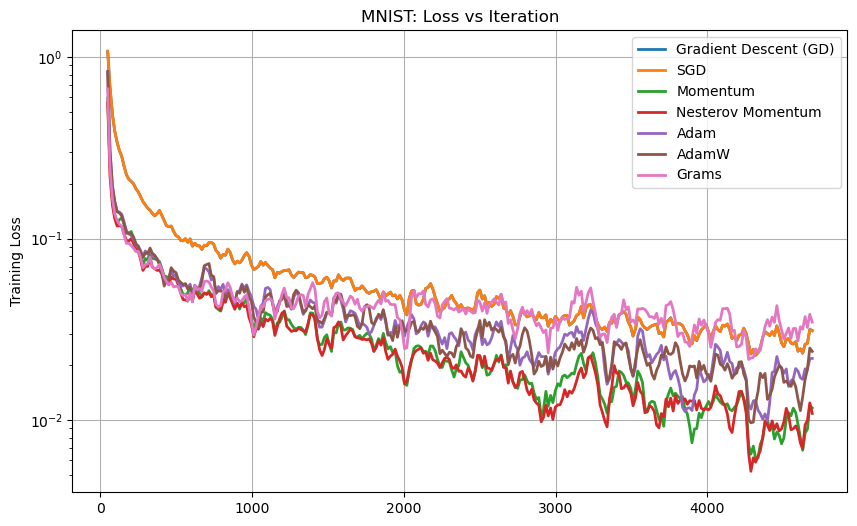

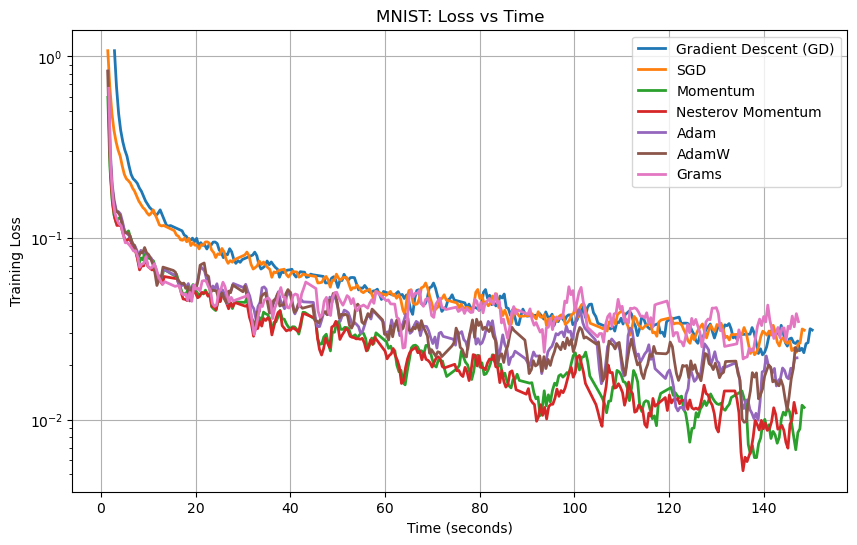

In [9]:
plt.figure(figsize=(10, 6))
for name, hist in histories_mnist.items():
    x = hist["iter_steps"]
    y = hist["iter_losses"]
    xs, ys = smooth_and_downsample(x, y, ma_window=50, max_points=300)
    plt.semilogy(xs, ys, label=name, linewidth=2)
plt.ylabel("Training Loss")
plt.title("MNIST: Loss vs Iteration")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, hist in histories_mnist.items():
    x = hist["iter_times"]
    y = hist["iter_losses"]
    xs, ys = smooth_and_downsample(x, y, ma_window=50, max_points=300)
    plt.semilogy(xs, ys, label=name, linewidth=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Training Loss")
plt.title("MNIST: Loss vs Time")
plt.grid(True)
plt.legend()
plt.show()

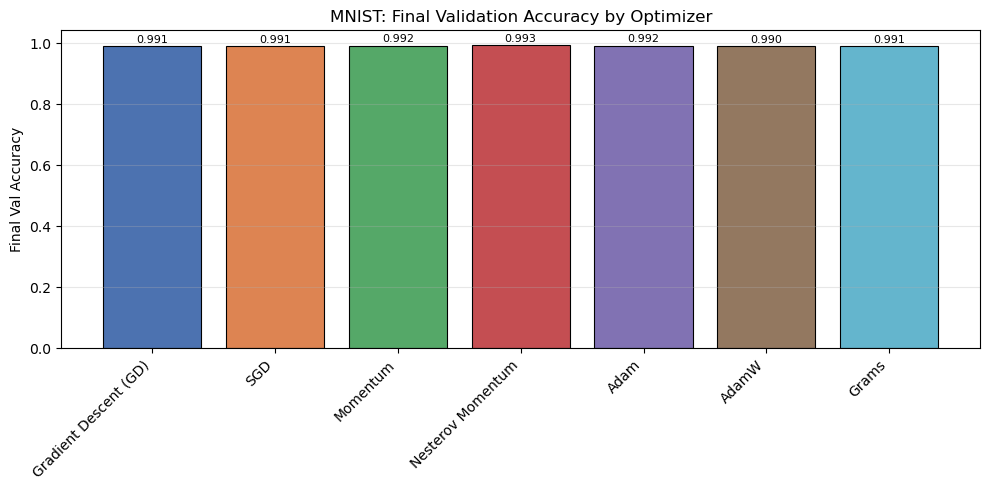

In [10]:
labels = []
accs = []

for name, hist in histories_mnist.items():
    labels.append(name)
    accs.append(hist["epoch_val_acc"][-1])

# Distinct colors (colorblind-safe and simple)
colors = [
    "#4c72b0",  # blue
    "#dd8452",  # orange
    "#55a868",  # green
    "#c44e52",  # red
    "#8172b3",  # purple
    "#937860",  # brown
    "#64b5cd"   # teal
]

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, accs, color=colors, edgecolor="black", linewidth=0.8)

# Add numeric labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.005,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.xticks(rotation=45, ha="right")
plt.ylabel("Final Val Accuracy")
plt.title("MNIST: Final Validation Accuracy by Optimizer")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


MNIST: per-optimizer loss variance (iteration-level):
Gradient Descent (GD) variance = 0.017136
SGD                  variance = 0.017137
Momentum             variance = 0.008058
Nesterov Momentum    variance = 0.007521
Adam                 variance = 0.016486
AdamW                variance = 0.016463
Grams                variance = 0.012318


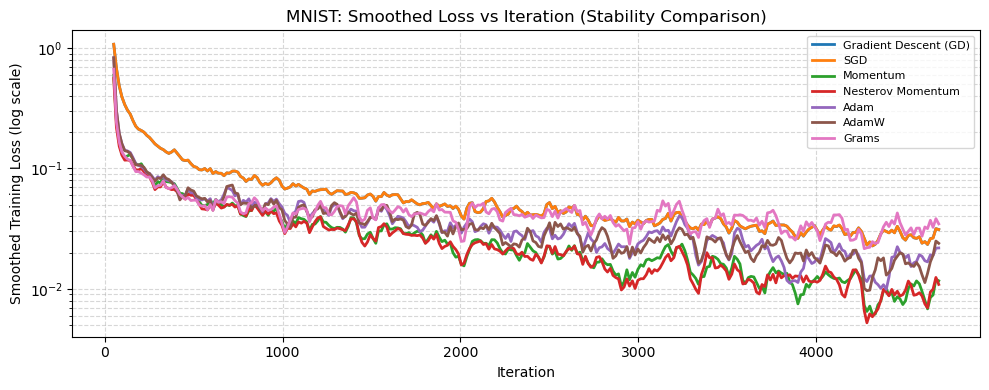

In [11]:
def moving_average(x, window=20):
    if len(x) < window:
        return np.array(x)
    return np.convolve(x, np.ones(window) / window, mode="valid")

print("MNIST: per-optimizer loss variance (iteration-level):")
for name, hist in histories_mnist.items():
    var = float(np.var(hist["iter_losses"]))
    print(f"{name:20s} variance = {var:.6f}")

plt.figure(figsize=(10, 4))

for name, hist in histories_mnist.items():
    x = hist["iter_steps"]
    y = hist["iter_losses"]

    xs, ys = smooth_and_downsample(x, y, ma_window=50, max_points=300)

    # LOG SCALE and nice line width
    plt.semilogy(xs, ys, label=name, linewidth=2)

plt.xlabel("Iteration")
plt.ylabel("Smoothed Training Loss (log scale)")
plt.title("MNIST: Smoothed Loss vs Iteration (Stability Comparison)")
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Smaller, cleaner legend
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

In [12]:
# Second dataset: Fashion-MNIST (Adam vs Grams)


=== Optimizer: Adam_Fashion ===


Adam_Fashion Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.3378, Val acc=0.8741


Adam_Fashion Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.2540, Val acc=0.9055


Adam_Fashion Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.2498, Val acc=0.9102


Adam_Fashion Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.2236, Val acc=0.9198


Adam_Fashion Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.2093, Val acc=0.9217


Adam_Fashion Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: Val loss=0.2167, Val acc=0.9245


Adam_Fashion Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: Val loss=0.2077, Val acc=0.9291


Adam_Fashion Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: Val loss=0.2132, Val acc=0.9266


Adam_Fashion Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: Val loss=0.2446, Val acc=0.9246


Adam_Fashion Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: Val loss=0.2561, Val acc=0.9210

=== Optimizer: Grams_Fashion ===


Grams_Fashion Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.3172, Val acc=0.8851


Grams_Fashion Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.2450, Val acc=0.9105


Grams_Fashion Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.2521, Val acc=0.9101


Grams_Fashion Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.2322, Val acc=0.9166


Grams_Fashion Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.2415, Val acc=0.9170


Grams_Fashion Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: Val loss=0.2278, Val acc=0.9240


Grams_Fashion Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: Val loss=0.2890, Val acc=0.9061


Grams_Fashion Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: Val loss=0.2324, Val acc=0.9218


Grams_Fashion Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: Val loss=0.2473, Val acc=0.9231


Grams_Fashion Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: Val loss=0.2390, Val acc=0.9203


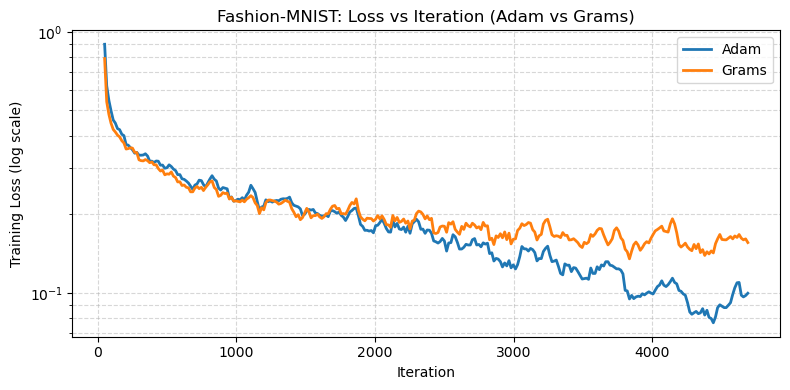

Fashion-MNIST final val acc:
Adam : 0.921
Grams: 0.9203


In [13]:
hist_fashion_adam = train_with_tracking(
    optimizer_name="Adam_Fashion",
    optimizer_factory=lambda p: adam_factory(p, lr=1e-3),
    train_loader=train_loader_fashion,
    test_loader=test_loader_fashion,
    num_epochs=10,
)

hist_fashion_grams = train_with_tracking(
    optimizer_name="Grams_Fashion",
    optimizer_factory=lambda p: grams_factory(p, lr=1e-3),
    train_loader=train_loader_fashion,
    test_loader=test_loader_fashion,
    num_epochs=10,
)

plt.figure(figsize=(8, 4))

# Adam
x_a = hist_fashion_adam["iter_steps"]
y_a = hist_fashion_adam["iter_losses"]
xs_a, ys_a = smooth_and_downsample(x_a, y_a, ma_window=50, max_points=300)
plt.semilogy(xs_a, ys_a, label="Adam", linewidth=2)

# Grams
x_g = hist_fashion_grams["iter_steps"]
y_g = hist_fashion_grams["iter_losses"]
xs_g, ys_g = smooth_and_downsample(x_g, y_g, ma_window=50, max_points=300)
plt.semilogy(xs_g, ys_g, label="Grams", linewidth=2)

plt.xlabel("Iteration")
plt.ylabel("Training Loss (log scale)")
plt.title("Fashion-MNIST: Loss vs Iteration (Adam vs Grams)")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print("Fashion-MNIST final val acc:")
print("Adam :",  hist_fashion_adam["epoch_val_acc"][-1])
print("Grams:", hist_fashion_grams["epoch_val_acc"][-1])

In [14]:
# Learning Rate Robustness


=== LR robustness: lr=0.0001 ===

=== Optimizer: SGD_lr=0.0001 ===


SGD_lr=0.0001 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=1.8213, Val acc=0.6782


SGD_lr=0.0001 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=1.4526, Val acc=0.7988


SGD_lr=0.0001 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=1.1625, Val acc=0.8499


SGD_lr=0.0001 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.9496, Val acc=0.8752


SGD_lr=0.0001 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.7944, Val acc=0.8901

=== Optimizer: Adam_lr=0.0001 ===


Adam_lr=0.0001 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0533, Val acc=0.9841


Adam_lr=0.0001 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0350, Val acc=0.9887


Adam_lr=0.0001 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0323, Val acc=0.9892


Adam_lr=0.0001 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0267, Val acc=0.9912


Adam_lr=0.0001 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0411, Val acc=0.9869

=== Optimizer: Grams_lr=0.0001 ===


Grams_lr=0.0001 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0734, Val acc=0.9786


Grams_lr=0.0001 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0478, Val acc=0.9847


Grams_lr=0.0001 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0384, Val acc=0.9876


Grams_lr=0.0001 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0363, Val acc=0.9877


Grams_lr=0.0001 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0300, Val acc=0.9895

=== LR robustness: lr=0.001 ===

=== Optimizer: SGD_lr=0.001 ===


SGD_lr=0.001 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.4308, Val acc=0.9253


SGD_lr=0.001 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.2433, Val acc=0.9489


SGD_lr=0.001 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.1780, Val acc=0.9584


SGD_lr=0.001 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.1449, Val acc=0.9643


SGD_lr=0.001 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.1238, Val acc=0.9690

=== Optimizer: Adam_lr=0.001 ===


Adam_lr=0.001 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0405, Val acc=0.9866


Adam_lr=0.001 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0451, Val acc=0.9860


Adam_lr=0.001 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0277, Val acc=0.9904


Adam_lr=0.001 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0237, Val acc=0.9922


Adam_lr=0.001 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0363, Val acc=0.9884

=== Optimizer: Grams_lr=0.001 ===


Grams_lr=0.001 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0480, Val acc=0.9834


Grams_lr=0.001 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0474, Val acc=0.9858


Grams_lr=0.001 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0314, Val acc=0.9892


Grams_lr=0.001 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0386, Val acc=0.9889


Grams_lr=0.001 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0359, Val acc=0.9911

=== LR robustness: lr=0.01 ===

=== Optimizer: SGD_lr=0.01 ===


SGD_lr=0.01 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0856, Val acc=0.9757


SGD_lr=0.01 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0585, Val acc=0.9812


SGD_lr=0.01 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0482, Val acc=0.9859


SGD_lr=0.01 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0406, Val acc=0.9878


SGD_lr=0.01 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0349, Val acc=0.9890

=== Optimizer: Adam_lr=0.01 ===


Adam_lr=0.01 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.2194, Val acc=0.9573


Adam_lr=0.01 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.1219, Val acc=0.9731


Adam_lr=0.01 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0625, Val acc=0.9834


Adam_lr=0.01 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0698, Val acc=0.9794


Adam_lr=0.01 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0326, Val acc=0.9905

=== Optimizer: Grams_lr=0.01 ===


Grams_lr=0.01 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0798, Val acc=0.9772


Grams_lr=0.01 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0778, Val acc=0.9771


Grams_lr=0.01 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0464, Val acc=0.9864


Grams_lr=0.01 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0637, Val acc=0.9812


Grams_lr=0.01 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0550, Val acc=0.9852

LR robustness results (final val accuracy):
SGD   | lr=1e-04 -> val_acc=0.8901
SGD   | lr=1e-03 -> val_acc=0.9690
SGD   | lr=1e-02 -> val_acc=0.9890
Adam  | lr=1e-04 -> val_acc=0.9869
Adam  | lr=1e-03 -> val_acc=0.9884
Adam  | lr=1e-02 -> val_acc=0.9905
Grams | lr=1e-04 -> val_acc=0.9895
Grams | lr=1e-03 -> val_acc=0.9911
Grams | lr=1e-02 -> val_acc=0.9852


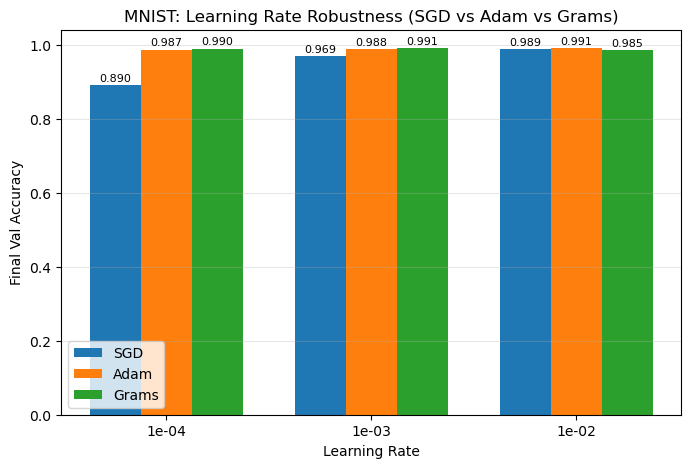

In [15]:
lrs = [1e-4, 1e-3, 1e-2]
lr_results = { "SGD": {}, "Adam": {}, "Grams": {} }

for lr in lrs:
    print(f"\n=== LR robustness: lr={lr} ===")

    # SGD
    hist_sgd = train_with_tracking(
        optimizer_name=f"SGD_lr={lr}",
        optimizer_factory=lambda p, lr=lr: sgd_factory(p, lr=lr),
        train_loader=train_loader_mnist,
        test_loader=test_loader_mnist,
        num_epochs=5,
    )
    lr_results["SGD"][lr] = hist_sgd["epoch_val_acc"][-1]

    hist_adam = train_with_tracking(
        optimizer_name=f"Adam_lr={lr}",
        optimizer_factory=lambda p, lr=lr: adam_factory(p, lr=lr),
        train_loader=train_loader_mnist,
        test_loader=test_loader_mnist,
        num_epochs=5,
    )
    lr_results["Adam"][lr] = hist_adam["epoch_val_acc"][-1]

    hist_grams = train_with_tracking(
        optimizer_name=f"Grams_lr={lr}",
        optimizer_factory=lambda p, lr=lr: grams_factory(p, lr=lr),
        train_loader=train_loader_mnist,
        test_loader=test_loader_mnist,
        num_epochs=5,
    )
    lr_results["Grams"][lr] = hist_grams["epoch_val_acc"][-1]

print("\nLR robustness results (final val accuracy):")
for opt_name, lr_dict in lr_results.items():
    for lr, acc in lr_dict.items():
        print(f"{opt_name:5s} | lr={lr:.0e} -> val_acc={acc:.4f}")

plt.figure(figsize=(8, 5))
x = np.arange(len(lrs))
width = 0.25

optimizers = ["SGD", "Adam", "Grams"]

for i, opt_name in enumerate(optimizers):
    vals = [lr_results[opt_name][lr] for lr in lrs]
    bars = plt.bar(x + i*width, vals, width=width, label=opt_name)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.005,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

plt.xticks(x + width, [f"{lr:.0e}" for lr in lrs])
plt.ylabel("Final Val Accuracy")
plt.xlabel("Learning Rate")
plt.title("MNIST: Learning Rate Robustness (SGD vs Adam vs Grams)")
plt.legend()
plt.grid(axis='y', alpha=0.3)

In [16]:
# Weight Decay Sensitivity (Adam vs. Grams)


=== Weight Decay: wd=0.0 ===

=== Optimizer: Adam_wd=0.0 ===


Adam_wd=0.0 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0457, Val acc=0.9851


Adam_wd=0.0 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0335, Val acc=0.9890


Adam_wd=0.0 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0331, Val acc=0.9897


Adam_wd=0.0 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0297, Val acc=0.9902


Adam_wd=0.0 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0489, Val acc=0.9848

=== Optimizer: Grams_wd=0.0 ===


Grams_wd=0.0 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0517, Val acc=0.9829


Grams_wd=0.0 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0416, Val acc=0.9874


Grams_wd=0.0 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0327, Val acc=0.9900


Grams_wd=0.0 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0407, Val acc=0.9883


Grams_wd=0.0 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0339, Val acc=0.9903

=== Weight Decay: wd=0.0001 ===

=== Optimizer: Adam_wd=0.0001 ===


Adam_wd=0.0001 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0391, Val acc=0.9868


Adam_wd=0.0001 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0352, Val acc=0.9876


Adam_wd=0.0001 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0341, Val acc=0.9892


Adam_wd=0.0001 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0243, Val acc=0.9926


Adam_wd=0.0001 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0621, Val acc=0.9799

=== Optimizer: Grams_wd=0.0001 ===


Grams_wd=0.0001 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0512, Val acc=0.9833


Grams_wd=0.0001 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0547, Val acc=0.9838


Grams_wd=0.0001 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0322, Val acc=0.9899


Grams_wd=0.0001 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0395, Val acc=0.9886


Grams_wd=0.0001 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0347, Val acc=0.9906

=== Weight Decay: wd=0.001 ===

=== Optimizer: Adam_wd=0.001 ===


Adam_wd=0.001 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0438, Val acc=0.9858


Adam_wd=0.001 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0383, Val acc=0.9878


Adam_wd=0.001 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0370, Val acc=0.9886


Adam_wd=0.001 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0297, Val acc=0.9903


Adam_wd=0.001 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0371, Val acc=0.9880

=== Optimizer: Grams_wd=0.001 ===


Grams_wd=0.001 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0499, Val acc=0.9827


Grams_wd=0.001 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0440, Val acc=0.9863


Grams_wd=0.001 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0341, Val acc=0.9885


Grams_wd=0.001 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0427, Val acc=0.9884


Grams_wd=0.001 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0372, Val acc=0.9908

=== Weight Decay: wd=0.01 ===

=== Optimizer: Adam_wd=0.01 ===


Adam_wd=0.01 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0754, Val acc=0.9807


Adam_wd=0.01 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0982, Val acc=0.9717


Adam_wd=0.01 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0630, Val acc=0.9830


Adam_wd=0.01 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0527, Val acc=0.9871


Adam_wd=0.01 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0524, Val acc=0.9868

=== Optimizer: Grams_wd=0.01 ===


Grams_wd=0.01 Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0498, Val acc=0.9835


Grams_wd=0.01 Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0380, Val acc=0.9884


Grams_wd=0.01 Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Val loss=0.0331, Val acc=0.9892


Grams_wd=0.01 Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Val loss=0.0388, Val acc=0.9891


Grams_wd=0.01 Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Val loss=0.0338, Val acc=0.9906

Weight decay robustness results (final val accuracy):
Adam  | wd=0e+00 -> val_acc=0.9848
Adam  | wd=1e-04 -> val_acc=0.9799
Adam  | wd=1e-03 -> val_acc=0.9880
Adam  | wd=1e-02 -> val_acc=0.9868
Grams | wd=0e+00 -> val_acc=0.9903
Grams | wd=1e-04 -> val_acc=0.9906
Grams | wd=1e-03 -> val_acc=0.9908
Grams | wd=1e-02 -> val_acc=0.9906


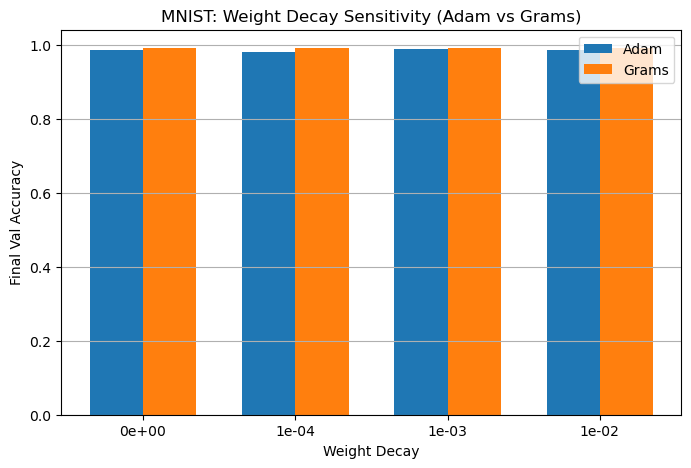

In [17]:
wds = [0.0, 1e-4, 1e-3, 1e-2]
wd_results = { "Adam": {}, "Grams": {} }

for wd in wds:
    print(f"\n=== Weight Decay: wd={wd} ===")

    hist_adam = train_with_tracking(
        optimizer_name=f"Adam_wd={wd}",
        optimizer_factory=lambda p, wd=wd: adam_factory(p, lr=1e-3, weight_decay=wd),
        train_loader=train_loader_mnist,
        test_loader=test_loader_mnist,
        num_epochs=5,
    )
    wd_results["Adam"][wd] = hist_adam["epoch_val_acc"][-1]

    hist_grams = train_with_tracking(
        optimizer_name=f"Grams_wd={wd}",
        optimizer_factory=lambda p, wd=wd: grams_factory(p, lr=1e-3, weight_decay=wd),
        train_loader=train_loader_mnist,
        test_loader=test_loader_mnist,
        num_epochs=5,
    )
    wd_results["Grams"][wd] = hist_grams["epoch_val_acc"][-1]

print("\nWeight decay robustness results (final val accuracy):")
for opt_name, wd_dict in wd_results.items():
    for wd, acc in wd_dict.items():
        print(f"{opt_name:5s} | wd={wd:.0e} -> val_acc={acc:.4f}")

plt.figure(figsize=(8, 5))
x = np.arange(len(wds))
width = 0.35

for i, opt_name in enumerate(["Adam", "Grams"]):
    vals = [wd_results[opt_name][wd] for wd in wds]
    plt.bar(x + i*width, vals, width=width, label=opt_name)

plt.xticks(x + width/2, [f"{wd:.0e}" for wd in wds])
plt.ylabel("Final Val Accuracy")
plt.xlabel("Weight Decay")
plt.title("MNIST: Weight Decay Sensitivity (Adam vs Grams)")
plt.legend()
plt.grid(axis='y')
plt.show()

In [18]:
# Per-layer gradient norms (Adam vs Grams)


=== Optimizer: Adam_gradnorms ===


Adam_gradnorms Epoch 1/2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0388, Val acc=0.9879


Adam_gradnorms Epoch 2/2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0299, Val acc=0.9901

=== Optimizer: Grams_gradnorms ===


Grams_gradnorms Epoch 1/2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0484, Val acc=0.9835


Grams_gradnorms Epoch 2/2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0383, Val acc=0.9873


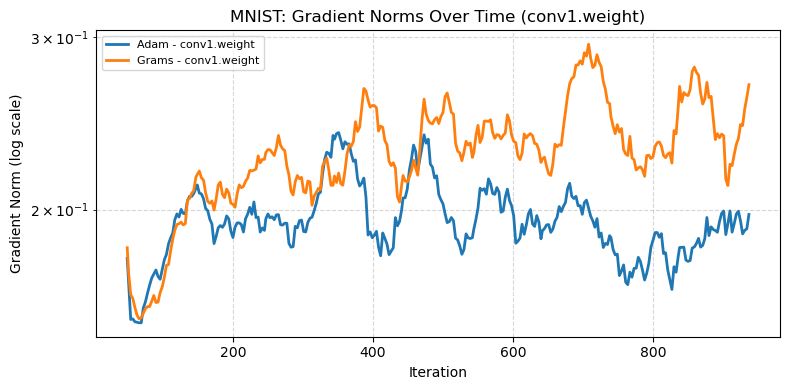

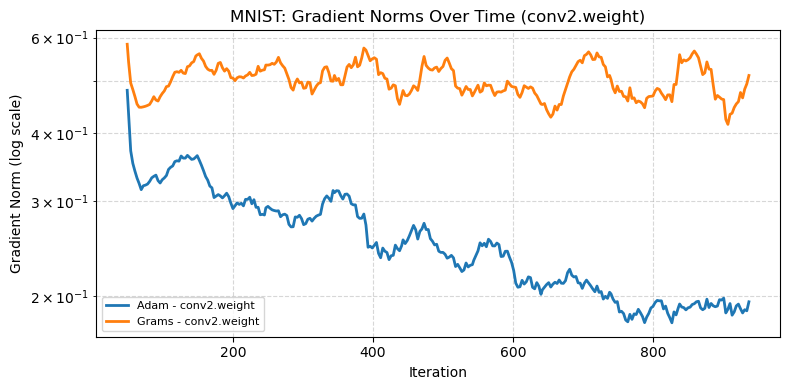

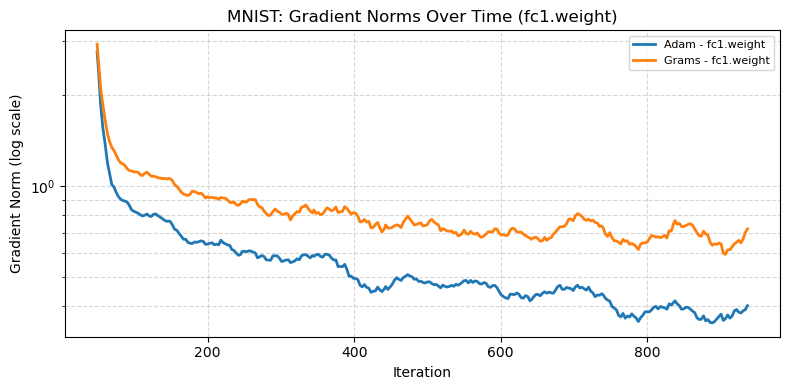

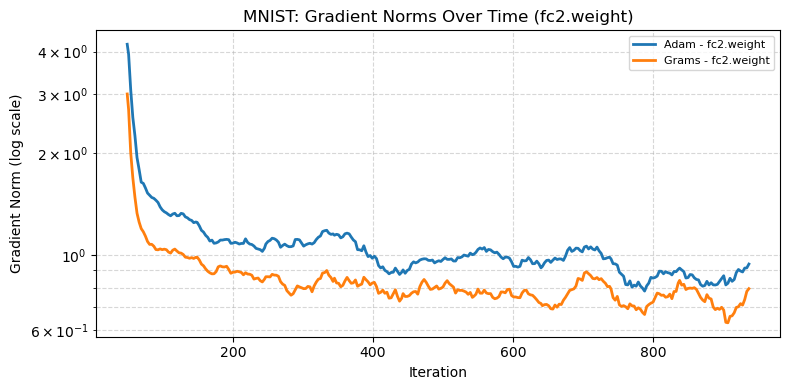

In [19]:
layers_to_track = [
    "conv1.weight",
    "conv2.weight",
    "fc1.weight",
    "fc2.weight",
]

hist_grad_adam = train_with_tracking(
    optimizer_name="Adam_gradnorms",
    optimizer_factory=lambda p: adam_factory(p, lr=1e-3),
    train_loader=train_loader_mnist,
    test_loader=test_loader_mnist,
    num_epochs=2,
    record_grad_norms=True,
    grad_layers=layers_to_track,
)

hist_grad_grams = train_with_tracking(
    optimizer_name="Grams_gradnorms",
    optimizer_factory=lambda p: grams_factory(p, lr=1e-3),
    train_loader=train_loader_mnist,
    test_loader=test_loader_mnist,
    num_epochs=2,
    record_grad_norms=True,
    grad_layers=layers_to_track,
)

for layer in layers_to_track:
    # x = iteration index
    x = np.arange(len(hist_grad_adam["grad_norms"][layer]))

    # Adam
    xs_a, ys_a = smooth_and_downsample(
        x, hist_grad_adam["grad_norms"][layer],
        ma_window=50, max_points=300
    )

    # Grams
    xs_g, ys_g = smooth_and_downsample(
        x, hist_grad_grams["grad_norms"][layer],
        ma_window=50, max_points=300
    )

    plt.figure(figsize=(8, 4))
    # log scale – makes relative differences clearer
    plt.semilogy(xs_a, ys_a, label=f"Adam - {layer}", linewidth=2)
    plt.semilogy(xs_g, ys_g, label=f"Grams - {layer}", linewidth=2)

    plt.xlabel("Iteration")
    plt.ylabel("Gradient Norm (log scale)")
    plt.title(f"MNIST: Gradient Norms Over Time ({layer})")
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

In [20]:
# Early training behavior (first N iterations)


=== Optimizer: SGD_short ===


SGD_short Epoch 1/2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0858, Val acc=0.9761


SGD_short Epoch 2/2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0587, Val acc=0.9813

=== Optimizer: Adam_short ===


Adam_short Epoch 1/2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0435, Val acc=0.9864


Adam_short Epoch 2/2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0319, Val acc=0.9888

=== Optimizer: Grams_short ===


Grams_short Epoch 1/2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Val loss=0.0508, Val acc=0.9829


Grams_short Epoch 2/2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Val loss=0.0426, Val acc=0.9863


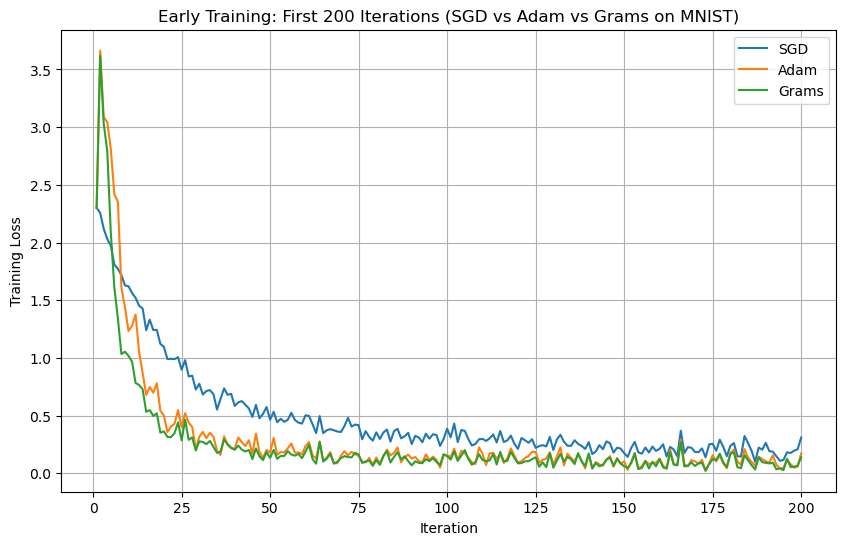

In [21]:
N = 200

def plot_early(histories_dict, title_suffix=""):
    plt.figure(figsize=(10, 6))
    for name, hist in histories_dict.items():
        steps = hist["iter_steps"][:N]
        losses = hist["iter_losses"][:N]
        plt.plot(steps, losses, label=name)
    plt.xlabel("Iteration")
    plt.ylabel("Training Loss")
    plt.title(f"Early Training: First {N} Iterations {title_suffix}")
    plt.grid(True)
    plt.legend()
    plt.show()

short_hist_sgd = train_with_tracking(
    optimizer_name="SGD_short",
    optimizer_factory=lambda p: sgd_factory(p, lr=0.01),
    train_loader=train_loader_mnist,
    test_loader=test_loader_mnist,
    num_epochs=2,
)

short_hist_adam = train_with_tracking(
    optimizer_name="Adam_short",
    optimizer_factory=lambda p: adam_factory(p, lr=1e-3),
    train_loader=train_loader_mnist,
    test_loader=test_loader_mnist,
    num_epochs=2,
)

short_hist_grams = train_with_tracking(
    optimizer_name="Grams_short",
    optimizer_factory=lambda p: grams_factory(p, lr=1e-3),
    train_loader=train_loader_mnist,
    test_loader=test_loader_mnist,
    num_epochs=2,
)

plot_early(
    {
        "SGD": short_hist_sgd,
        "Adam": short_hist_adam,
        "Grams": short_hist_grams,
    },
    title_suffix="(SGD vs Adam vs Grams on MNIST)",
)

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def adam_step(x, y, dx, dy, s, lr=0.01):
    b1, b2, eps = 0.9, 0.999, 1e-8
    s['t'] += 1
    s['mx'] = b1*s['mx'] + (1-b1)*dx
    s['my'] = b1*s['my'] + (1-b1)*dy
    s['vx'] = b2*s['vx'] + (1-b2)*dx**2
    s['vy'] = b2*s['vy'] + (1-b2)*dy**2
    mxh = s['mx']/(1-b1**s['t'])
    myh = s['my']/(1-b1**s['t'])
    vxh = s['vx']/(1-b2**s['t'])
    vyh = s['vy']/(1-b2**s['t'])
    return x - lr*mxh/(np.sqrt(vxh)+eps), y - lr*myh/(np.sqrt(vyh)+eps)

def grams_step(x, y, dx, dy, s, lr=0.01):
    b1, b2, eps = 0.9, 0.999, 1e-8
    s['t'] += 1
    s['mx'] = b1*s['mx'] + (1-b1)*abs(dx)
    s['my'] = b1*s['my'] + (1-b1)*abs(dy)
    s['vx'] = b2*s['vx'] + (1-b2)*dx**2
    s['vy'] = b2*s['vy'] + (1-b2)*dy**2
    mxh = s['mx']/(1-b1**s['t'])
    myh = s['my']/(1-b1**s['t'])
    vxh = s['vx']/(1-b2**s['t'])
    vyh = s['vy']/(1-b2**s['t'])
    return x - lr*np.sign(dx)*mxh/(np.sqrt(vxh)+eps), y - lr*np.sign(dy)*myh/(np.sqrt(vyh)+eps)

# Test functions
rosenbrock = lambda x, y: (1-x)**2 + 100*(y-x**2)**2
rosenbrock_grad = lambda x, y: (np.array([-2*(1-x) - 400*x*(y-x**2), 200*(y-x**2)]))
elongated_valley = lambda x, y: 100*x**2 + y**2
elongated_valley_grad = lambda x, y: (np.array([200*x, 2*y]))

In [50]:
def run_opt(opt_fn, func, grad_fn, x0, y0, n_iter, lr):
    s = {'t': 0, 'mx': 0.0, 'my': 0.0, 'vx': 0.0, 'vy': 0.0}
    x, y = x0, y0
    losses = []
    for _ in range(n_iter):
        losses.append(func(x, y))
        g = grad_fn(x, y)
        x, y = opt_fn(x, y, g[0], g[1], s, lr)
    return losses, func(x, y)

# Rosenbrock
rose_adam = run_opt(adam_step, rosenbrock, rosenbrock_grad, -1.5, 2.5, 2000, 0.01)
rose_grams = run_opt(grams_step, rosenbrock, rosenbrock_grad, -1.5, 2.5, 2000, 0.01)

# Elongated Valley
valley_adam = run_opt(adam_step, elongated_valley, elongated_valley_grad, 1.0, 1.0, 200, 0.1)
valley_grams = run_opt(grams_step, elongated_valley, elongated_valley_grad, 1.0, 1.0, 200, 0.1)

# Results
print("\nRESULTS:")
print(f"{'Problem':<20} {'Adam':<15} {'Grams':<15}")
print(f"{'Rosenbrock':<20} {rose_adam[1]:<15.6f} {rose_grams[1]:<15.6f}")
print(f"{'Elongated Valley':<20} {valley_adam[1]:<15.2e} {valley_grams[1]:<15.2e}")


RESULTS:
Problem              Adam            Grams          
Rosenbrock           0.008292        0.002798       
Elongated Valley     5.26e-09        7.63e-13       


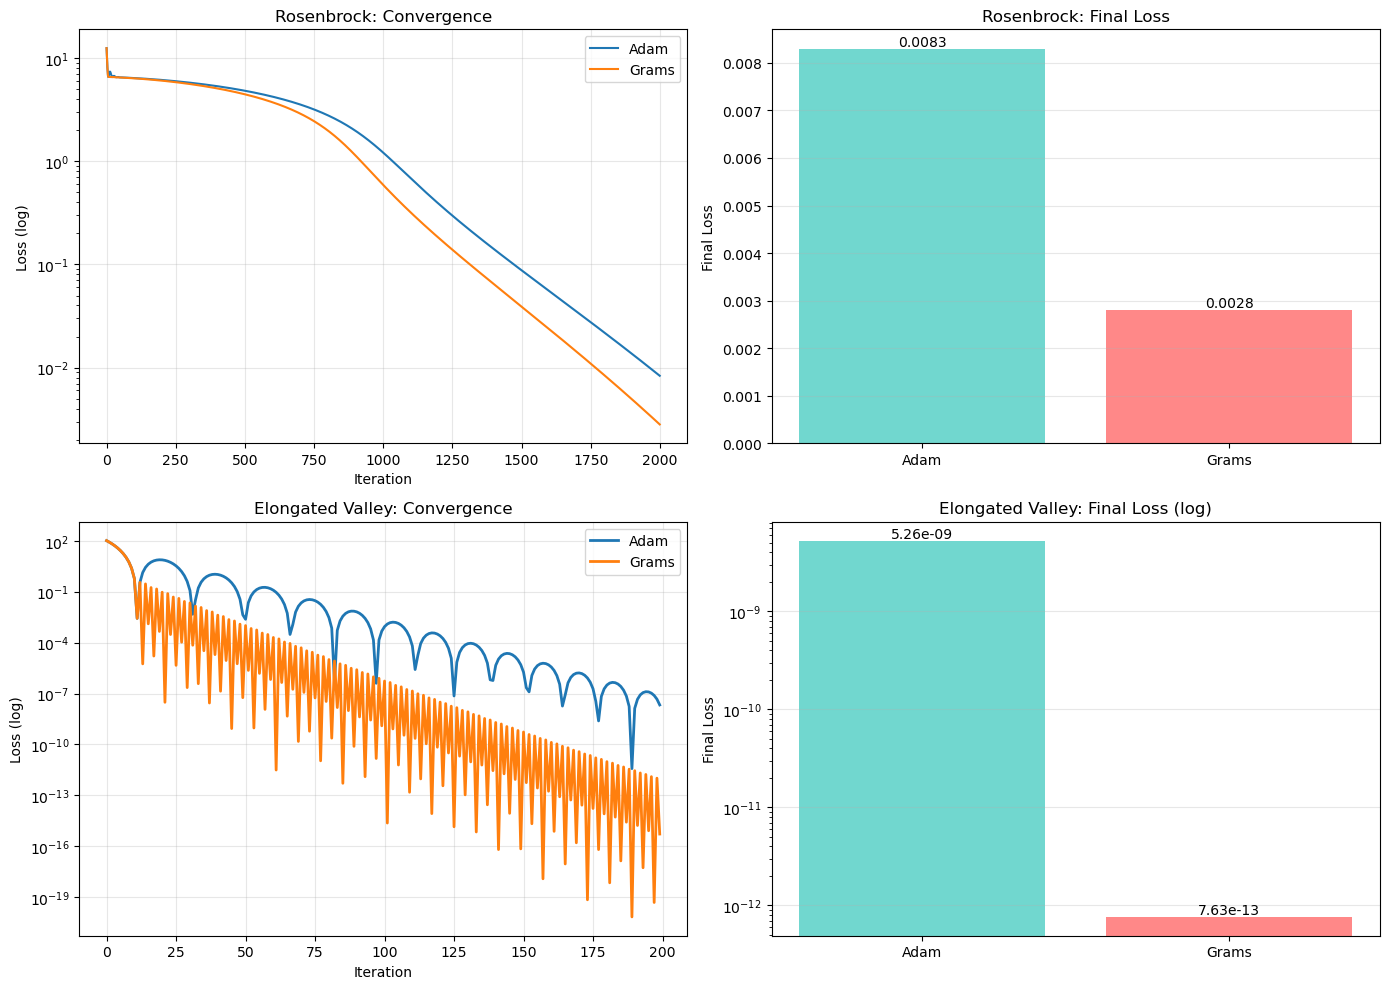

Grams wins on both optimization benchmarks
Rosenbrock: 66.3% better
Elongated Valley: 100.0% better


In [51]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rosenbrock convergence
axes[0,0].semilogy(rose_adam[0], label='Adam')
axes[0,0].semilogy(rose_grams[0], label='Grams')
axes[0,0].set_xlabel("Iteration")
axes[0,0].set_ylabel("Loss (log)")
axes[0,0].set_title("Rosenbrock: Convergence")
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Rosenbrock final
axes[0,1].bar(['Adam', 'Grams'], [rose_adam[1], rose_grams[1]], 
              color=['#4ECDC4', '#FF6B6B'], alpha=0.8)
axes[0,1].set_ylabel("Final Loss")
axes[0,1].set_title("Rosenbrock: Final Loss")
axes[0,1].grid(axis='y', alpha=0.3)
for i, v in enumerate([rose_adam[1], rose_grams[1]]):
    axes[0,1].text(i, v, f'{v:.4f}', ha='center', va='bottom')

# Valley convergence
axes[1,0].semilogy(valley_adam[0], label='Adam', linewidth=2)
axes[1,0].semilogy(valley_grams[0], label='Grams', linewidth=2)
axes[1,0].set_xlabel("Iteration")
axes[1,0].set_ylabel("Loss (log)")
axes[1,0].set_title("Elongated Valley: Convergence")
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# Valley final
axes[1,1].bar(['Adam', 'Grams'], [valley_adam[1], valley_grams[1]], 
              color=['#4ECDC4', '#FF6B6B'], alpha=0.8)
axes[1,1].set_ylabel("Final Loss")
axes[1,1].set_yscale("log")
axes[1,1].set_title("Elongated Valley: Final Loss (log)")
axes[1,1].grid(axis='y', alpha=0.3)
for i, v in enumerate([valley_adam[1], valley_grams[1]]):
    axes[1,1].text(i, v, f'{v:.2e}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Summary
grams_better = sum([rose_grams[1] < rose_adam[1], valley_grams[1] < valley_adam[1]])
print(f"Grams wins on both optimization benchmarks")
print(f"Rosenbrock: {((rose_adam[1]-rose_grams[1])/rose_adam[1]*100):.1f}% better")
print(f"Elongated Valley: {((valley_adam[1]-valley_grams[1])/valley_adam[1]*100):.1f}% better")
